In [1]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import scatter_matrix
from itertools import combinations
import scipy.stats as stats
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from fancyimpute import KNN
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import metrics, cross_validation
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor

/Users/evanhosmer/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/evanhosmer/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Project Description

For this project, I will be exploring three of my personal playlists on spotify for my three favorite genres of music. In addition, I have created two playlists of music which I like and music which I don't in order to perform a logisitic regression and predict whether or not I will like a song. These playlists will be explored utilizing Spotify's API and the spotipy program in python. For this analysis, I will be attempting to answer 2 main questions:
```
1) Can I predict the popularity for a song based on the audio features of the song?
```
```
2) Can I predict whether I will like a song based on audio features (Kaggle dataset)?
```

## Data Selection

For this case study, the three genres of music that I will be exploring are alternative, hard rock, and metalcore. For each of these genres, I have created a spotify playlist ranging from 400 to 650 songs. Using Spotify API, I am able to pull audio features for each of the songs in the particular playlist. These features are quantitative descriptions of a particular song. Features include accousticness, energy, danceability, instrumentalness, etc. There are a total of 14 different audio features for each song which will be used as features in a linear regression model. The target variable for linear regression will be a variable called popularity, which is a quantitative representation of how popular a particular song is.

In addition, using a dataset provided from Kaggle, I will investigate how well a logistic regression model can predict whether or not a user likes a song or not. The dataset contains a combination of two playlists: One that the user likes all the songs in and one where the user does not like all the songs in. Using the same audio features, a logistic regression model will be made to see how well these features predict whether a user likes a song or not.

## Data Acquistion ##

By using Spotify API and the python library called Spotipy, I am able to extract the songs from each playlist. From this, I can use spotipy's get_audio_features for each song and store these features for each song into a pandas dataframe. Similarly, these tracks all have a metric called popularity which can be extracted and placed into the same dataframe and used as the target for linear regression. The dataset for logistic regresion is acquired from Kaggle where the user used the same API process to generate the audio data.

## Data Cleansing

In [3]:
run Spotify_audio_features.py

Runs a python script to obtain the dataframes for the alternative, hard rock, and metalcore playlists with the desired audio features. Note: try to improve speed of script when I get the chance. Luckily in this data, there are no NaN values since the audio features are described in full for each particular song in the playlists.

In [6]:
alternative.to_csv('alternative.csv')
hard_rock.to_csv('hard_rock.csv')
metal_core.to_csv('metal_core.csv')

## EDA

The track_href column provides nothing of value, drop the column from the dataframes

In [14]:
alternative.drop(['track_href'], axis=1,inplace = True)
hard_rock.drop(['track_href'], axis=1,inplace = True)
metal_core.drop(['track_href'], axis=1,inplace = True)
alternative

KeyError: "labels ['track_href'] not contained in axis"

Get an idea of the range of the popularity metric and the most popular songs from each playlist

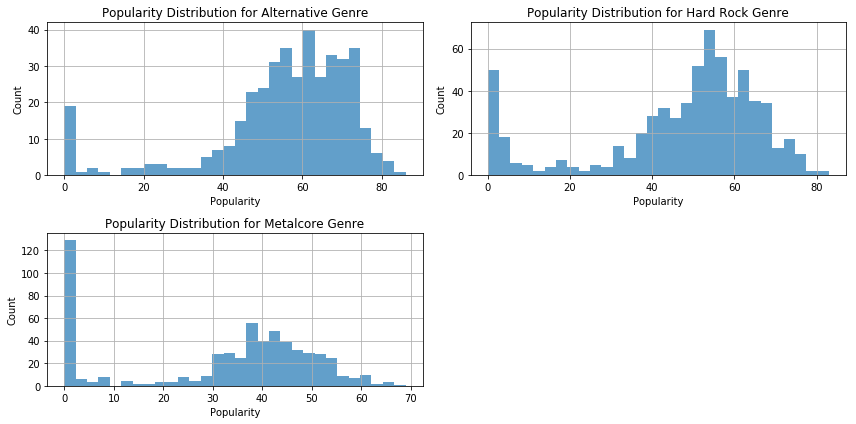

In [15]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(221)
alternative['Popularity'].hist(alpha=0.7, bins=30)
ax.set_title('Popularity Distribution for Alternative Genre')
ax.set_xlabel('Popularity')
ax.set_ylabel('Count')
ax1 = fig.add_subplot(222)
hard_rock['Popularity'].hist(alpha=0.7, bins=30)
ax1.set_title('Popularity Distribution for Hard Rock Genre')
ax1.set_xlabel('Popularity')
ax1.set_ylabel('Count')
ax2 = fig.add_subplot(223)
metal_core['Popularity'].hist(alpha=0.7, bins=30)
ax2.set_title('Popularity Distribution for Metalcore Genre')
ax2.set_xlabel('Popularity')
ax2.set_ylabel('Count')

plt.tight_layout()

Many songs for the Hard Rock and Metalcore playlists have a popularity of 0, this might cause problems later. From intuition this result is not surprising because in general these genres are much less popular.

In [16]:
alt = alternative['Popularity'].mean()
rock = hard_rock['Popularity'].mean()
metal = metal_core['Popularity'].mean()
print(alt,rock,metal)

55.40493827160494 46.83925811437403 31.767284991568296


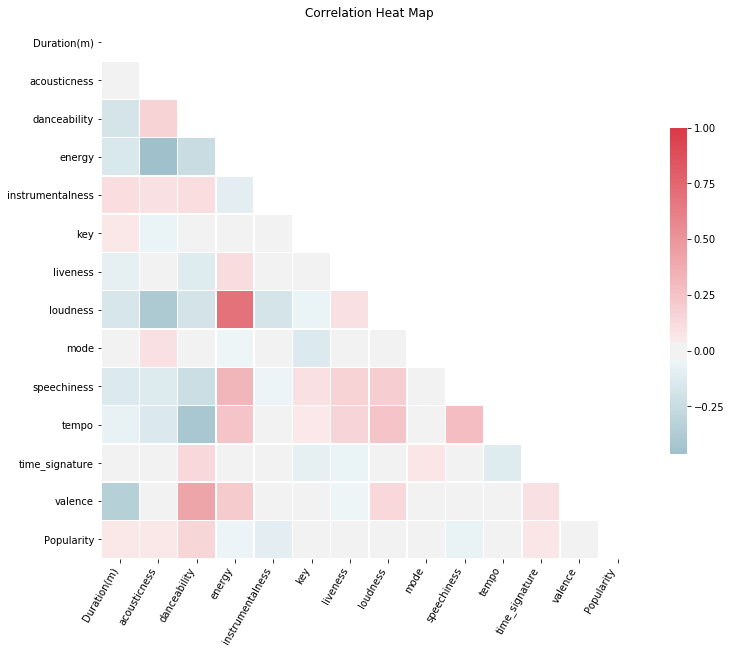

<Figure size 432x288 with 0 Axes>

In [17]:
def corr_heat(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(12, 12))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},xticklabels=corr.index, yticklabels=corr.columns)
    plt.xticks(rotation=60, ha="right")
    plt.yticks(rotation=0)
    ax.set_title("Correlation Heat Map")
    plt.show()
    plt.savefig('Corr_map.png',dpi = 400)

corr_heat(alternative)


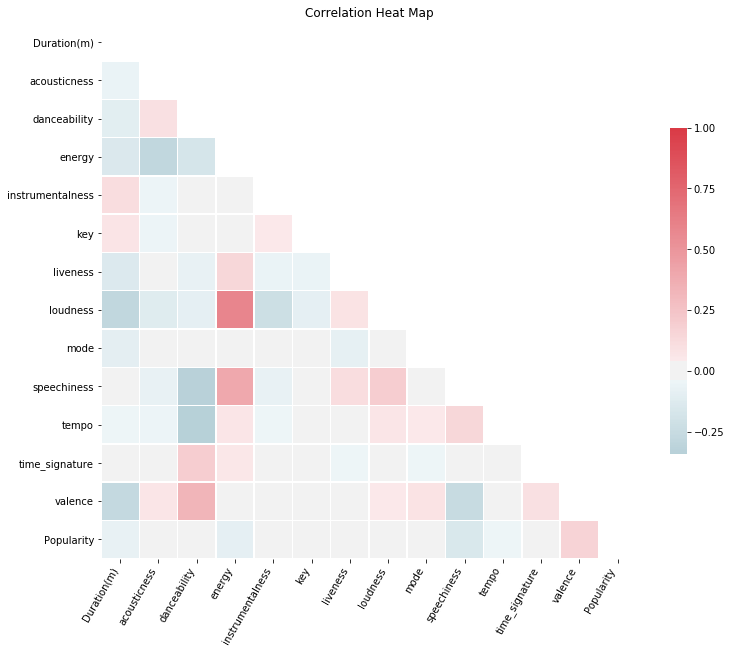

<Figure size 432x288 with 0 Axes>

In [18]:
corr_heat(hard_rock)

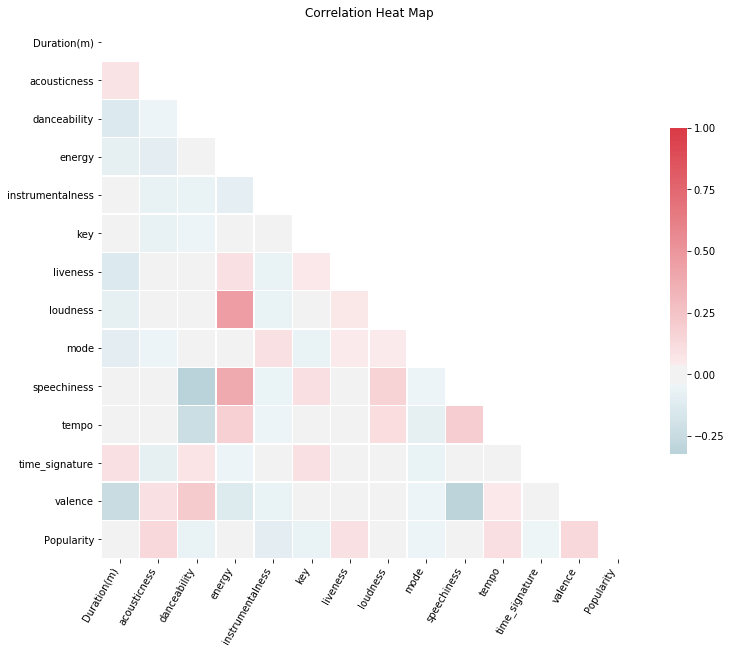

<Figure size 432x288 with 0 Axes>

In [19]:
corr_heat(metal_core)

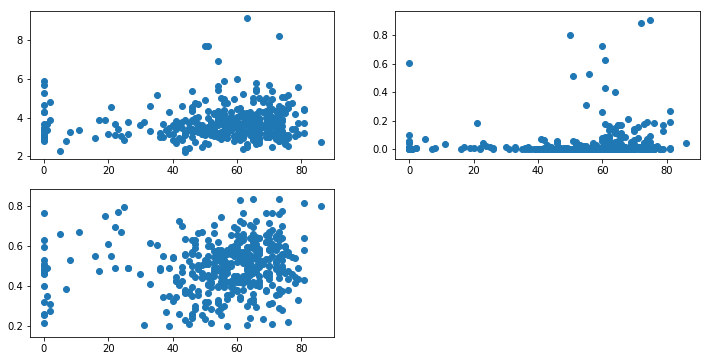

In [20]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(221)

ax.scatter(alternative['Popularity'],alternative['Duration(m)'])

ax2 = fig.add_subplot(222)
ax2.scatter(alternative['Popularity'],alternative['acousticness'])
ax3 = fig.add_subplot(223)
ax3.scatter(alternative['Popularity'],alternative['danceability'])

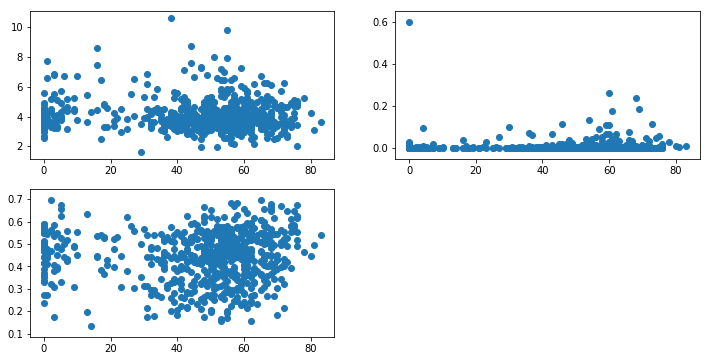

In [21]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(221)

ax.scatter(hard_rock['Popularity'],hard_rock['Duration(m)'])

ax2 = fig.add_subplot(222)
ax2.scatter(hard_rock['Popularity'],hard_rock['acousticness'])
ax3 = fig.add_subplot(223)
ax3.scatter(hard_rock['Popularity'],hard_rock['danceability'])

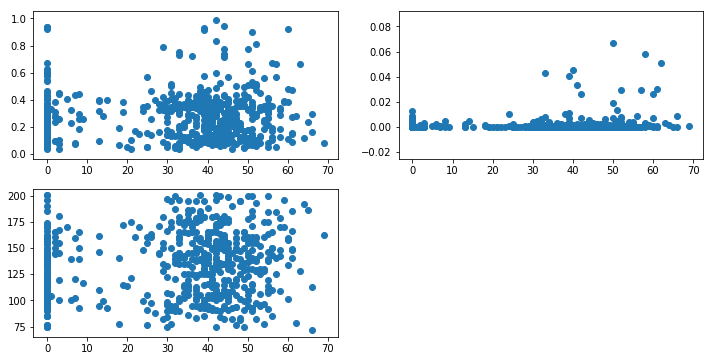

In [22]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(221)

ax.scatter(metal_core['Popularity'],metal_core['liveness'])

ax2 = fig.add_subplot(222)
ax2.scatter(metal_core['Popularity'],metal_core['acousticness'])
ax3 = fig.add_subplot(223)
ax3.scatter(metal_core['Popularity'],metal_core['tempo'])

An interesting hypothesis test would involve seeing if there was a statistically significant difference in the mean popularity from the three genres of music

## Combined Genres

In [114]:
altpop = alternative['Popularity']
rockpop = hard_rock['Popularity']
metalpop = metal_core['Popularity']
alternative['Genre'] = 'Alternative'
hard_rock['Genre'] = 'Hard Rock'
metal_core['Genre'] = 'Metalcore'
combineddf = pd.concat([alternative,hard_rock])
final = pd.concat([combineddf,metal_core])
pd.set_option('display.float_format', lambda x: '%.3f' % x)
speaker_df = final.groupby('Artist').count().reset_index()[['Artist','Duration(m)']]
speaker_df.columns = ['artist', 'appearances']
speaker_df = speaker_df.sort_values('appearances', ascending=False)
artists = final.groupby('Artist').mean().reset_index()
df = artists.sample(frac = 1)
df.head()

,Artist,Duration(m),acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,Popularity
190,Palisades,4.615,0.001,0.493,0.975,0.000,9.000,0.270,-5.371,0.000,0.080,135.014,4.000,0.255,46.000
68,Cruel Hand,1.636,0.000,0.498,0.921,0.116,4.000,0.083,-4.430,1.000,0.046,75.003,4.000,0.639,29.000
5,A Skylit Drive,3.210,0.001,0.238,0.935,0.000,1.000,0.262,-2.105,0.000,0.063,119.402,4.000,0.734,45.000
43,Born Of Osiris,3.810,0.001,0.387,0.969,0.061,6.000,0.121,-3.794,0.750,0.192,157.454,3.750,0.170,40.500
227,Shinedown,3.827,0.001,0.445,0.877,0.002,4.882,0.167,-3.648,0.588,0.066,138.254,3.882,0.363,56.000


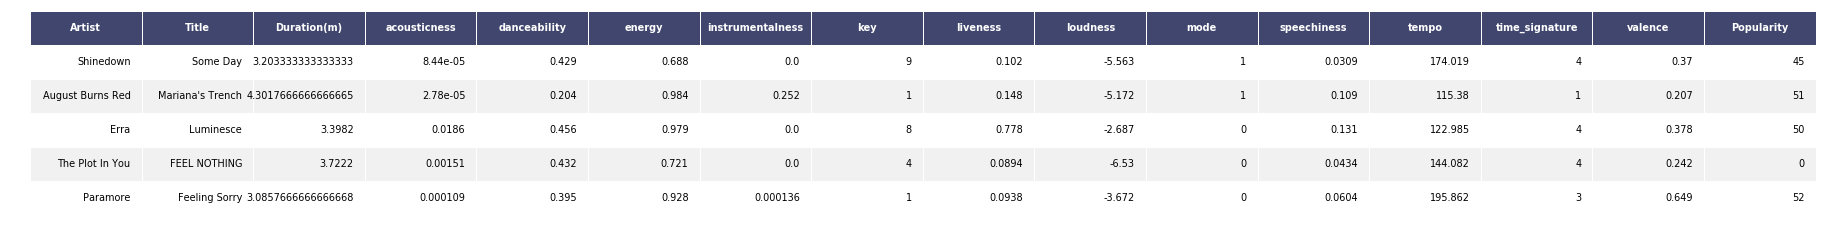

In [109]:
df = final.sample(frac = 1)
df2 = df.head()
df3 = df2.drop('Genre',axis = 1)
df3

import six
def render_mpl_table(data, col_width=7.0, row_height=0.625, font_size=9.75,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(df3, header_columns=0, col_width=2.0)

(array([216.,  25.,   7.,  16.,  18.,  19.,  33.,  67.,  91., 142., 163.,
        157., 161., 164., 115., 108.,  90.,  38.,  13.,   2.]),
 array([ 0. ,  4.3,  8.6, 12.9, 17.2, 21.5, 25.8, 30.1, 34.4, 38.7, 43. ,
        47.3, 51.6, 55.9, 60.2, 64.5, 68.8, 73.1, 77.4, 81.7, 86. ]),
 <a list of 20 Patch objects>)

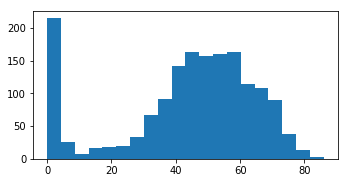

In [102]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(221)

ax.hist(final['Popularity'],20)

In [25]:

# X is the complete data matrix
# X_incomplete has the same values as X except a subset have been replace with NaN
t = final['Popularity'].replace(0,np.nan)
t2 = final.drop('Popularity',axis = 1)
t3 = pd.concat([t2,t],axis = 1)
t3[t3['Title'] == 'Hammerhead']
X_incomplete = t3.drop(['Artist','Title','Genre'],axis = 1)
# Use 3 nearest rows which have a feature to fill in each row's missing features
X_filled_knn = KNN(k=10).complete(X_incomplete)
cols = X_incomplete.columns
f = pd.DataFrame(X_filled_knn, columns = cols).reset_index()
f1 = final[['Title','Artist','Genre']].reset_index()
finalkn = pd.concat([f1,f],axis = 1)
finalknn = finalkn.drop(['index'],axis = 1)

Imputing row 1/1645 with 0 missing, elapsed time: 0.416
Imputing row 101/1645 with 0 missing, elapsed time: 0.417
Imputing row 201/1645 with 0 missing, elapsed time: 0.417
Imputing row 301/1645 with 0 missing, elapsed time: 0.418
Imputing row 401/1645 with 0 missing, elapsed time: 0.418
Imputing row 501/1645 with 0 missing, elapsed time: 0.419
Imputing row 601/1645 with 0 missing, elapsed time: 0.419
Imputing row 701/1645 with 0 missing, elapsed time: 0.420
Imputing row 801/1645 with 0 missing, elapsed time: 0.421
Imputing row 901/1645 with 0 missing, elapsed time: 0.421
Imputing row 1001/1645 with 0 missing, elapsed time: 0.422
Imputing row 1101/1645 with 0 missing, elapsed time: 0.422
Imputing row 1201/1645 with 0 missing, elapsed time: 0.423
Imputing row 1301/1645 with 0 missing, elapsed time: 0.424
Imputing row 1401/1645 with 0 missing, elapsed time: 0.425
Imputing row 1501/1645 with 0 missing, elapsed time: 0.425
Imputing row 1601/1645 with 1 missing, elapsed time: 0.426


In [26]:
finalknn[finalknn['Title'] == 'Hammerhead']


,Title,Artist,Genre,Duration(m),acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,Popularity
120,Hammerhead,The Offspring,Alternative,4.641,0.002,0.485,0.950,0.008,11.000,0.076,-3.571,1.000,0.054,154.427,4.000,0.510,33.435


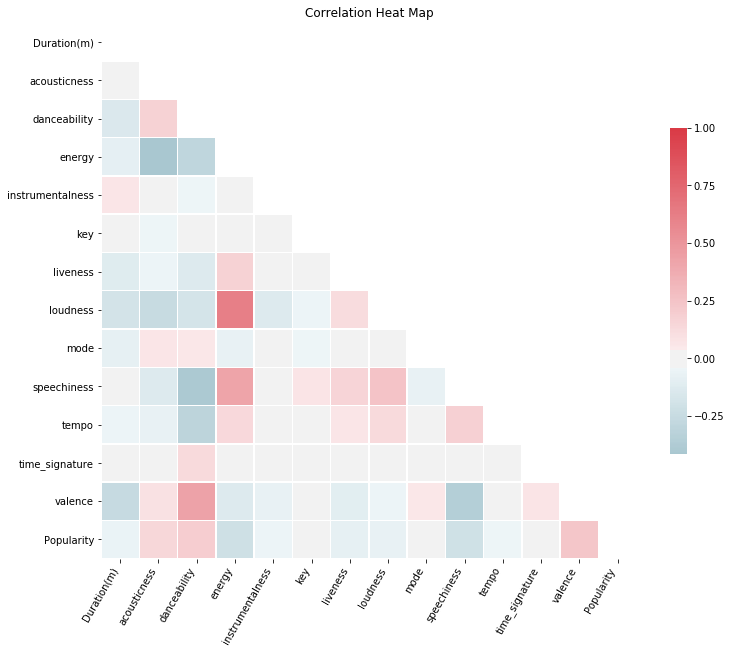

<Figure size 432x288 with 0 Axes>

In [27]:
corr_heat(finalknn)

This plot shows that the most positive correlation with popularity occurs with the acousticness, danceability, and valence variables. high valence = more positive sounding song while low valence = more negative sounding song. The most negatively correlated features are energy and speechiness.

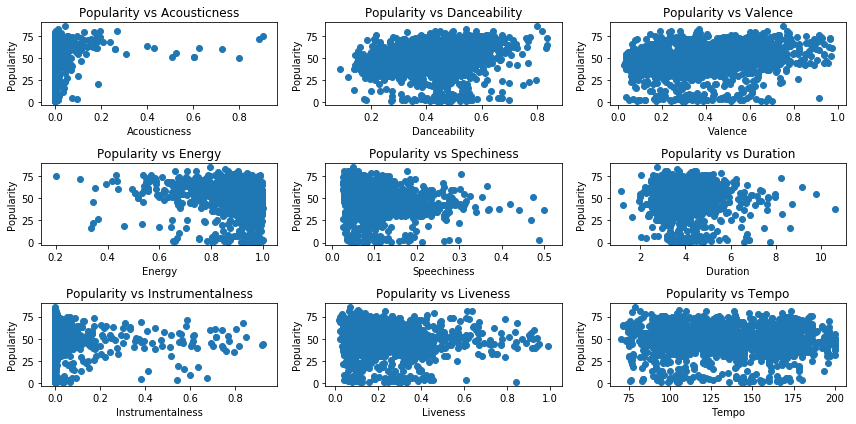

In [28]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(331)
ax.scatter(finalknn['acousticness'],finalknn['Popularity'])
ax.set_title('Popularity vs Acousticness')
ax.set_xlabel('Acousticness')
ax.set_ylabel('Popularity')
ax1 = fig.add_subplot(332)
ax1.scatter(finalknn['danceability'],finalknn['Popularity'])
ax1.set_title('Popularity vs Danceability')
ax1.set_xlabel('Danceability')
ax1.set_ylabel('Popularity')
ax2 = fig.add_subplot(333)
ax2.scatter(finalknn['valence'],finalknn['Popularity'])
ax2.set_title('Popularity vs Valence')
ax2.set_xlabel('Valence')
ax2.set_ylabel('Popularity')
ax3 = fig.add_subplot(334)
ax3.scatter(finalknn['energy'],finalknn['Popularity'])
ax3.set_title('Popularity vs Energy')
ax3.set_xlabel('Energy')
ax3.set_ylabel('Popularity')
ax4 = fig.add_subplot(335)
ax4.scatter(finalknn['speechiness'],finalknn['Popularity'])
ax4.set_title('Popularity vs Spechiness')
ax4.set_xlabel('Speechiness')
ax4.set_ylabel('Popularity')
ax5 = fig.add_subplot(336)
ax5.scatter(finalknn['Duration(m)'],finalknn['Popularity'])
ax5.set_title('Popularity vs Duration')
ax5.set_xlabel('Duration')
ax5.set_ylabel('Popularity')
ax6 = fig.add_subplot(337)
ax6.scatter(finalknn['instrumentalness'],finalknn['Popularity'])
ax6.set_title('Popularity vs Instrumentalness')
ax6.set_xlabel('Instrumentalness')
ax6.set_ylabel('Popularity')
ax7 = fig.add_subplot(338)
ax7.scatter(finalknn['liveness'],finalknn['Popularity'])
ax7.set_title('Popularity vs Liveness')
ax7.set_xlabel('Liveness')
ax7.set_ylabel('Popularity')
ax8 = fig.add_subplot(339)
ax8.scatter(finalknn['tempo'],finalknn['Popularity'])
ax8.set_title('Popularity vs Tempo')
ax8.set_xlabel('Tempo')
ax8.set_ylabel('Popularity')


plt.tight_layout()

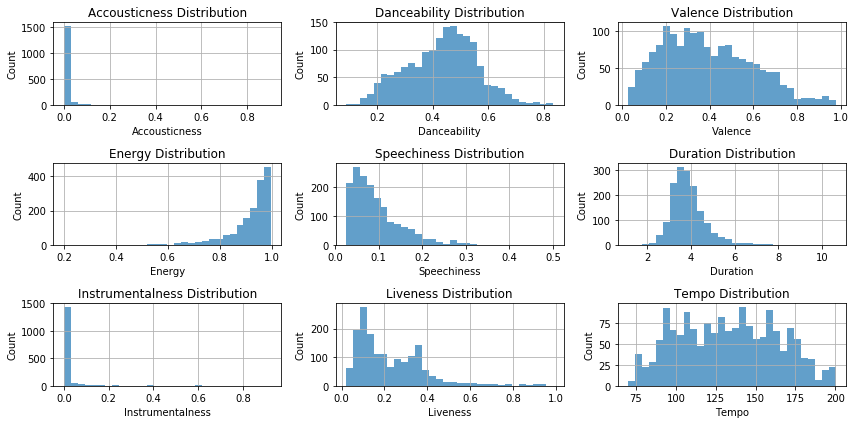

In [29]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(331)
finalknn['acousticness'].hist(alpha = 0.7,bins =30)
ax.set_title('Accousticness Distribution')
ax.set_xlabel('Accousticness')
ax.set_ylabel('Count')
ax1 = fig.add_subplot(332)
finalknn['danceability'].hist(alpha = 0.7,bins =30)
ax1.set_title('Danceability Distribution')
ax1.set_xlabel('Danceability')
ax1.set_ylabel('Count')
ax2 = fig.add_subplot(333)
finalknn['valence'].hist(alpha = 0.7,bins =30)
ax2.set_title('Valence Distribution')
ax2.set_xlabel('Valence')
ax2.set_ylabel('Count')
ax3 = fig.add_subplot(334)
finalknn['energy'].hist(alpha = 0.7,bins =30)
ax3.set_title('Energy Distribution')
ax3.set_xlabel('Energy')
ax3.set_ylabel('Count')
ax4 = fig.add_subplot(335)
finalknn['speechiness'].hist(alpha = 0.7,bins =30)
ax4.set_title('Speechiness Distribution')
ax4.set_xlabel('Speechiness')
ax4.set_ylabel('Count')
ax5 = fig.add_subplot(336)
finalknn['Duration(m)'].hist(alpha = 0.7,bins =30)
ax5.set_title('Duration Distribution')
ax5.set_xlabel('Duration')
ax5.set_ylabel('Count')
ax6 = fig.add_subplot(337)
finalknn['instrumentalness'].hist(alpha = 0.7,bins =30)
ax6.set_title('Instrumentalness Distribution')
ax6.set_xlabel('Instrumentalness')
ax6.set_ylabel('Count')
ax7 = fig.add_subplot(338)
finalknn['liveness'].hist(alpha = 0.7,bins =30)
ax7.set_title('Liveness Distribution')
ax7.set_xlabel('Liveness')
ax7.set_ylabel('Count')
ax8 = fig.add_subplot(339)
finalknn['tempo'].hist(alpha = 0.7,bins =30)
ax8.set_title('Tempo Distribution')
ax8.set_xlabel('Tempo')
ax8.set_ylabel('Count')

plt.tight_layout()

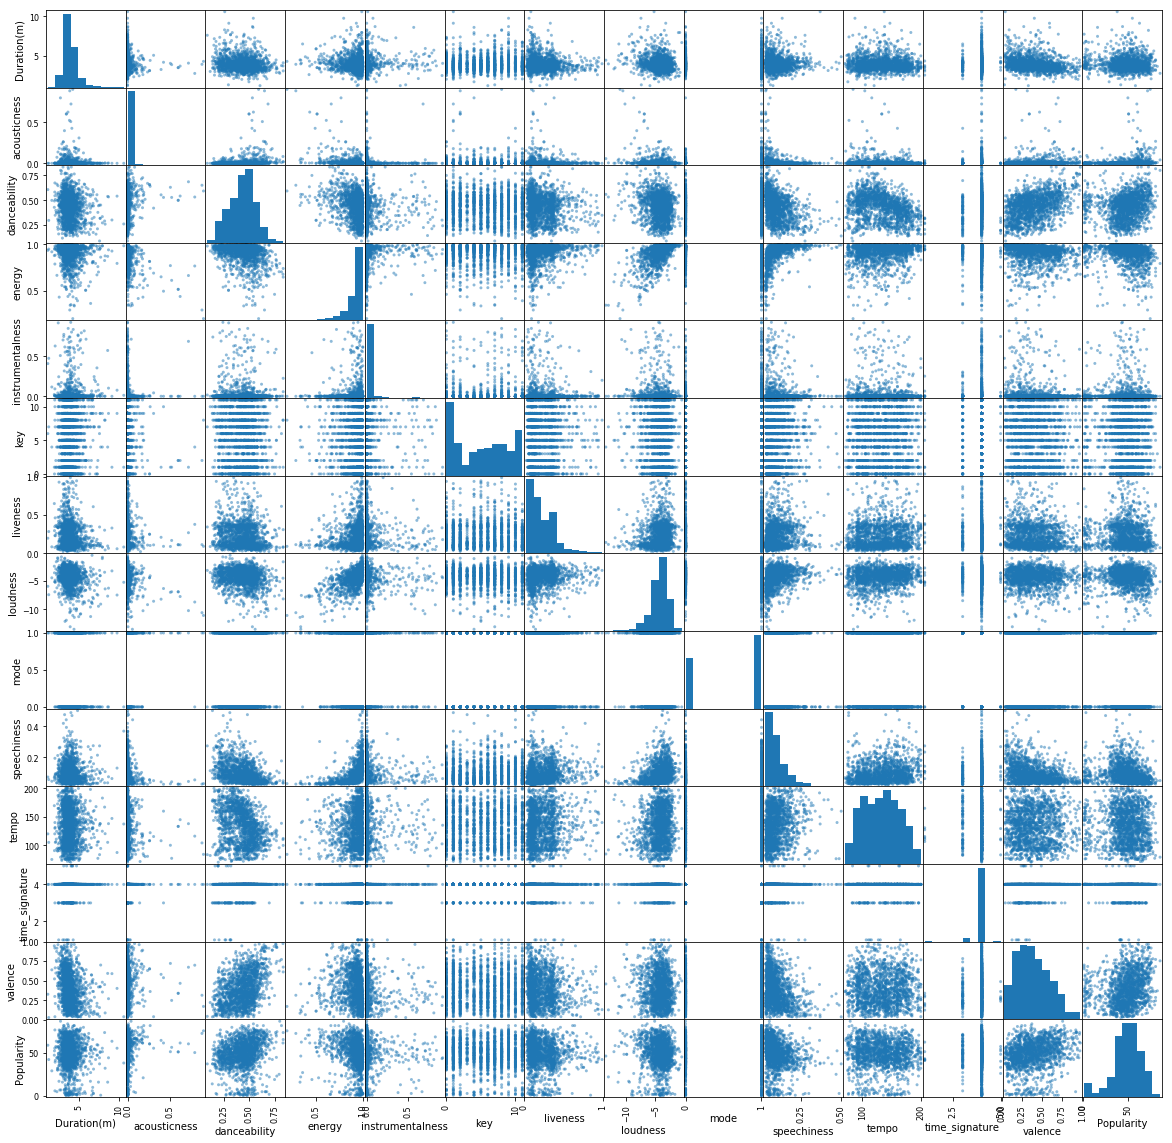

In [30]:
t = scatter_matrix(finalknn, figsize=(20, 20))

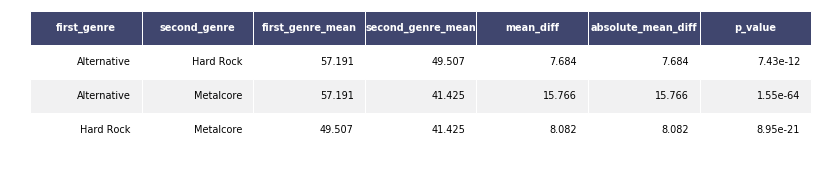

In [31]:
combos = combinations(pd.unique(finalknn['Genre']), 2)
results = pd.DataFrame()
for age_group_1, age_group_2 in combos:
    age_group_1_ctr = finalknn[finalknn.Genre == age_group_1]['Popularity']
    age_group_2_ctr = finalknn[finalknn.Genre == age_group_2]['Popularity']
    p_value = stats.ttest_ind(age_group_1_ctr, age_group_2_ctr, equal_var=True)[1]
    age_group_1_ctr_mean = age_group_1_ctr.mean()
    age_group_2_ctr_mean = age_group_2_ctr.mean()
    diff = age_group_1_ctr_mean-age_group_2_ctr_mean
    absolute_diff = abs(age_group_1_ctr_mean-age_group_2_ctr_mean)
    results = results.append({
              'first_genre':age_group_1, 'second_genre':age_group_2, 
              'first_genre_mean':age_group_1_ctr_mean, 'second_genre_mean':age_group_2_ctr_mean,
              'mean_diff':diff, 'absolute_mean_diff':absolute_diff, 'p_value':p_value},
              ignore_index=True)

results = results[['first_genre', 'second_genre', 
                   'first_genre_mean', 'second_genre_mean', 
                   'mean_diff', 'absolute_mean_diff', 'p_value']]

new = results.round({'first_genre_mean': 3,'second_genre_mean': 3,'mean_diff': 3,'absolute_mean_diff': 3})
a = [7.43e-12,1.55e-64,8.95e-21]
new.loc[:, 'p_value'] = a
import six
def render_mpl_table(data, col_width=7.0, row_height=0.625, font_size=9.75,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(new, header_columns=0, col_width=2.0)

This table shows that there is a statistically significant difference in mean popularity between the three genres of music.

## Linear Regression

First, we need to deal with the songs that have 0 popularity

In [32]:
test = final[final['Popularity'] == 0]
nozero = final[final['Popularity'] != 0]


In [33]:
met = test[test['Genre'] == 'Metalcore']
met['Popularity'] = metal
altz = test[test['Genre'] == 'Alternative']
altz['Popularity'] = alt
hr = test[test['Genre'] == 'Hard Rock']
hr['Popularity'] = rock

new = pd.concat([met,altz,hr])
new

mergeddf = pd.concat([nozero,new])

/Users/evanhosmer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/evanhosmer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/evanhosmer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [34]:
s = mergeddf['Genre']
dummies = pd.get_dummies(s)
x = mergeddf.drop('Genre',axis = 1)
new = pd.concat([x,dummies], axis = 1)

s2 = finalknn['Genre']
dummies2 = pd.get_dummies(s2)
x2 = finalknn.drop('Genre',axis = 1)
df_dummies = pd.concat([x2,dummies2],axis = 1 )

Text(0,0.5,'Count')

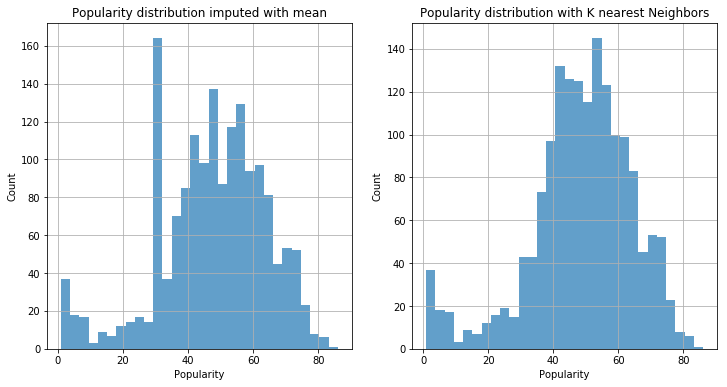

In [35]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(121)

mergeddf['Popularity'].hist(alpha=0.7, bins=30)
ax.set_title('Popularity distribution imputed with mean')
ax.set_xlabel('Popularity')
ax.set_ylabel('Count')
ax2 = fig.add_subplot(122)

finalknn['Popularity'].hist(alpha=0.7, bins=30)
ax2.set_title('Popularity distribution with K nearest Neighbors')
ax2.set_xlabel('Popularity')
ax2.set_ylabel('Count')

In [153]:
X = df_dummies.drop(['Title','Artist','Popularity'],axis = 1)
y = df_dummies['Popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
type(X_train)

pandas.core.frame.DataFrame

                            OLS Regression Results                            
Dep. Variable:             Popularity   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     21.39
Date:                Thu, 28 Jun 2018   Prob (F-statistic):           9.57e-54
Time:                        15:51:32   Log-Likelihood:                -6744.7
No. Observations:                1645   AIC:                         1.352e+04
Df Residuals:                    1629   BIC:                         1.361e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Duration(m)         -0.2707      0.434  

Text(0,0.5,'Studentized Residuals')

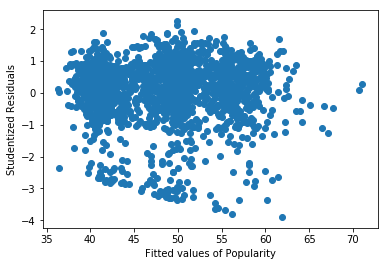

In [154]:
mod = sm.OLS(endog=y, exog=X).fit()
print(mod.summary())
student_resid = mod.outlier_test()['student_resid']
plt.scatter(mod.fittedvalues, student_resid)
plt.xlabel('Fitted values of Popularity')
plt.ylabel('Studentized Residuals')

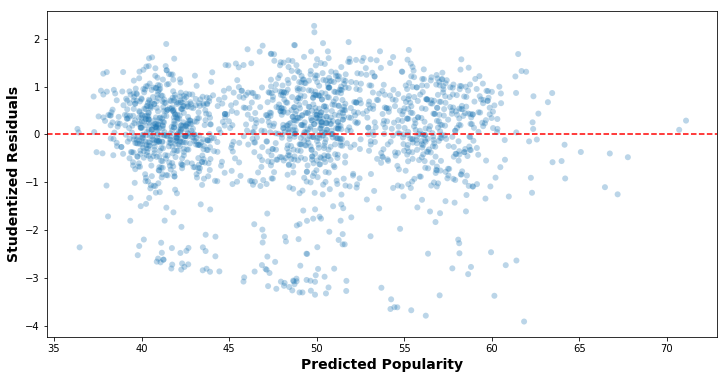

In [130]:
fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(111)

student_resid = mod.outlier_test()['student_resid']
ax1.scatter(mod.fittedvalues, student_resid, edgecolor='none', alpha=.3)
ax1.set_xlabel('Predicted Popularity', fontsize=14, fontweight='bold')
ax1.set_ylabel('Studentized Residuals', fontsize=14, fontweight='bold')
ax1.axhline(0, color='r', linestyle='--')

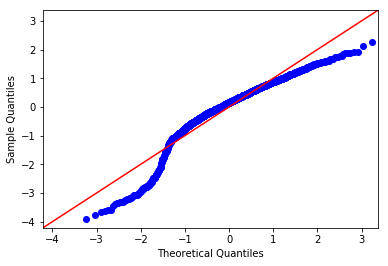

In [131]:
sm.graphics.qqplot(student_resid, line='45', fit=True)
plt.show()

In [128]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

Split the data 80/20 into train and test set

## Ridge Regression w/ Optimal Alpha

Predicted Prob (x) vs Actual Prob(y)

In [38]:
ridge = Ridge(alpha = 0.5)
ridge.fit(X_train,y_train)
type(X_train)

pandas.core.frame.DataFrame

In [39]:
def rss(y, y_hat):
    return np.mean((y  - y_hat)**2)

In [40]:
preds = ridge.predict(X_test)
mse = rss(y_test, preds)
print("MSE for Ridge(alpha=0.5): {:2.2f}".format(mse))

MSE for Ridge(alpha=0.5): 202.82


In [41]:
def cv(X, y, base_estimator, n_folds, random_seed=154):
    kf = KFold(n_folds, random_state=random_seed)
    test_cv_errors, train_cv_errors = np.empty(n_folds), np.empty(n_folds)
    for idx, (train, test) in enumerate(kf.split(X)):
        # Split into train and test
        X_cv_train, y_cv_train = X[train], y[train]
        X_cv_test, y_cv_test = X[test], y[test]
        # Standardize data
        standardizer = StandardScaler()
        standardizer.fit(X_cv_train, y_cv_train)
        X_cv_train_std = standardizer.transform(X_cv_train)
#         y_cv_train_std = standardizer.transform(y_cv_train)
        X_cv_test_std = standardizer.transform(X_cv_test)
#         y_cv_test_std = standardizer.transform(y_cv_test)

        # not standardizing targets
        y_cv_train_std = y_cv_train
        y_cv_test_std = y_cv_test

        # X_cv_train_std, y_cv_train_std = X_cv_train, y_cv_train
        # X_cv_test_std, y_cv_test_std = X_cv_test, y_cv_test

        # Fit estimator
        estimator = clone(base_estimator)
        estimator.fit(X_cv_train_std, y_cv_train_std)

        # Measure performance
        y_hat_train = estimator.predict(X_cv_train_std)
        y_hat_test = estimator.predict(X_cv_test_std)
        # Calculate the error metrics
        train_cv_errors[idx] = rss(y_cv_train_std, y_hat_train)
        test_cv_errors[idx] = rss(y_cv_test_std, y_hat_test)
    return train_cv_errors, test_cv_errors

In [42]:
n_folds = 10
train_cv_errors, test_cv_errors = cv(X_train.values, y_train.values,Ridge(alpha=0.5), n_folds=n_folds)
print("Training CV error: {:2.2f}".format(train_cv_errors.mean()))
print("Test CV error: {:2.2f}".format(test_cv_errors.mean()))

Training CV error: 216.08
Test CV error: 221.36


In [43]:
def train_at_various_alphas(X, y, model, alphas, n_folds=10, **kwargs):
    cv_errors_train = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                     columns=alphas)
    cv_errors_test = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                        columns=alphas)
    for alpha in alphas:
        train_fold_errors, test_fold_errors = cv(X, y, model(alpha=alpha, **kwargs), n_folds=n_folds)
        cv_errors_train.loc[:, alpha] = train_fold_errors
        cv_errors_test.loc[:, alpha] = test_fold_errors
    return cv_errors_train, cv_errors_test

In [44]:
ridge_alphas = np.logspace(-2, 4, num=250)

ridge_cv_errors_train, ridge_cv_errors_test = train_at_various_alphas(
    X_train.values, y_train.values, Ridge, ridge_alphas)

In [45]:
ridge_mean_cv_errors_train = ridge_cv_errors_train.mean(axis=0)
ridge_mean_cv_errors_test = ridge_cv_errors_test.mean(axis=0)

In [46]:
def get_optimal_alpha(mean_cv_errors_test):
    alphas = mean_cv_errors_test.index
    optimal_idx = np.argmin(mean_cv_errors_test.values)
    optimal_alpha = alphas[optimal_idx]
    return optimal_alpha

ridge_optimal_alpha = get_optimal_alpha(ridge_mean_cv_errors_test)
ridge_optimal_alpha

184.1027352562163

Text(0,0.5,'MSE')

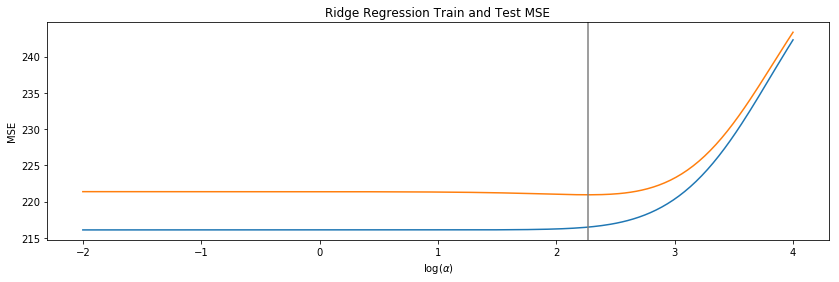

In [47]:
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(np.log10(ridge_alphas), ridge_mean_cv_errors_train)
ax.plot(np.log10(ridge_alphas), ridge_mean_cv_errors_test)
ax.axvline(np.log10(ridge_optimal_alpha), color='grey')
ax.set_title("Ridge Regression Train and Test MSE")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("MSE")

In [48]:
n_folds = 10
train_cv_errors, test_cv_errors = cv(X_train.values, y_train.values,Ridge(alpha=ridge_optimal_alpha), n_folds=n_folds)
print("Training CV error: {:2.2f}".format(train_cv_errors.mean()))
print("Test CV error: {:2.2f}".format(test_cv_errors.mean()))

Training CV error: 216.46
Test CV error: 220.93


## Lasso

In [49]:
lasso_alphas = np.logspace(-3, 1, num=250)

lasso_cv_errors_train, lasso_cv_errors_test = train_at_various_alphas(
    X_train.values, y_train.values, Lasso, lasso_alphas, max_iter=5000)

Text(0,0.5,'MSE')

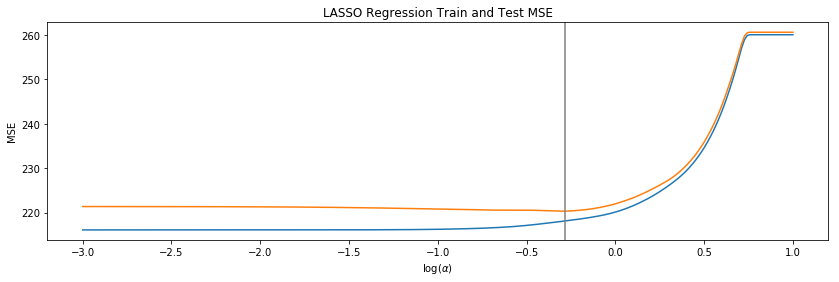

In [50]:
lasso_mean_cv_errors_train = lasso_cv_errors_train.mean(axis=0)
lasso_mean_cv_errors_test = lasso_cv_errors_test.mean(axis=0)

lasso_optimal_alpha = get_optimal_alpha(lasso_mean_cv_errors_test)
    
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(np.log10(lasso_alphas), lasso_mean_cv_errors_train)
ax.plot(np.log10(lasso_alphas), lasso_mean_cv_errors_test)
ax.axvline(np.log10(lasso_optimal_alpha), color='grey')
ax.set_title("LASSO Regression Train and Test MSE")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("MSE")

## Model Comparison

In [51]:
standardizer = StandardScaler()
standardizer.fit(X_train.values, y_train.values)
X_train_std = standardizer.transform(X_train.values)
X_test_std = standardizer.transform(X_test.values)
y_train_std = y_train
y_test_std = y_test

In [52]:
final_ridge = Ridge(alpha=ridge_optimal_alpha).fit(X_train_std, y_train_std)
final_lasso = Lasso(alpha=lasso_optimal_alpha).fit(X_train_std, y_train_std)
final_lr = LinearRegression().fit(X_train_std, y_train_std)

In [53]:
final_ridge_rss = rss(y_test_std, final_ridge.predict(X_test_std))
final_lasso_rss = rss(y_test_std, final_lasso.predict(X_test_std))
final_lr_rss = rss(y_test_std, final_lr.predict(X_test_std))

In [54]:
print("Final Ridge RMSE: {:2.3f}".format(np.sqrt(final_ridge_rss)))
print("Final Lasso RMSE: {:2.3f}".format(np.sqrt(final_lasso_rss)))
print("Final Linear Regression RMSE: {:2.3f}".format(np.sqrt(final_lr_rss)))

Final Ridge RMSE: 14.213
Final Lasso RMSE: 14.280
Final Linear Regression RMSE: 14.244


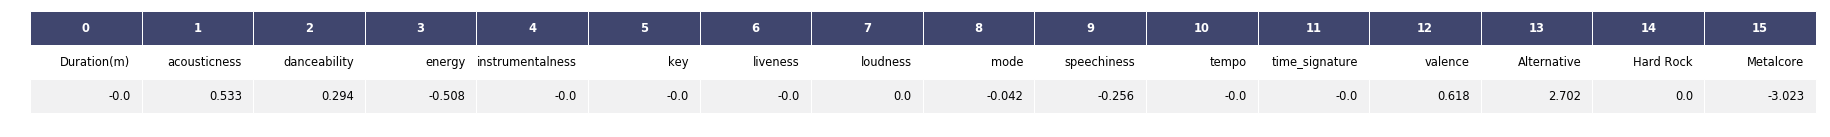

In [122]:
coeffs = final_lasso.coef_
b = coeffs.reshape(16,1)
cols = X.columns
t = pd.DataFrame(b)
t2 = t.set_index(cols)
t2.columns = ['Coefficient']
t3 = t2.reset_index()
t3.columns = ['Feature','Coefficient']
t4 = t3.round({'Coefficient': 3})
t5 = t4.T
import six
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=11.5,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(t5, header_columns=0, col_width=2.0)

## Elastic Net

In [56]:
X = df_dummies.drop(['Title','Artist','Popularity'],axis = 1)
y = df_dummies['Popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [57]:
def train_at_various_alphas_en(X, y, model, alphas, n_folds=10, **kwargs):
    cv_errors_train = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                     columns=alphas)
    cv_errors_test = pd.DataFrame(np.empty(shape=(n_folds, len(alphas))),
                                        columns=alphas)
    for alpha in alphas:
        train_fold_errors, test_fold_errors = cv(X, y, model(alpha=alpha, l1_ratio = 0.5,**kwargs), n_folds=n_folds)
        cv_errors_train.loc[:, alpha] = train_fold_errors
        cv_errors_test.loc[:, alpha] = test_fold_errors
    return cv_errors_train, cv_errors_test

Text(0,0.5,'MSE')

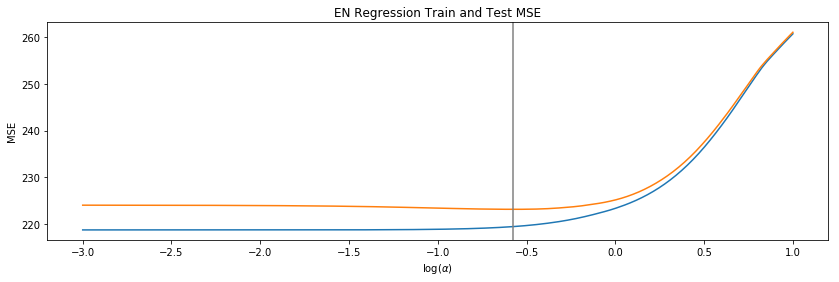

In [58]:
en_alphas = np.logspace(-3, 1, num=250)

en_cv_errors_train, en_cv_errors_test = train_at_various_alphas_en(
    X_train.values, y_train.values, ElasticNet, en_alphas, max_iter=5000)

en_mean_cv_errors_train = en_cv_errors_train.mean(axis=0)
en_mean_cv_errors_test = en_cv_errors_test.mean(axis=0)

en_optimal_alpha = get_optimal_alpha(en_mean_cv_errors_test)
    
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(np.log10(en_alphas), en_mean_cv_errors_train)
ax.plot(np.log10(en_alphas), en_mean_cv_errors_test)
ax.axvline(np.log10(en_optimal_alpha), color='grey')
ax.set_title("EN Regression Train and Test MSE")
ax.set_xlabel(r"$\log(\alpha)$")
ax.set_ylabel("MSE")

In [66]:
final_en = ElasticNet(alpha = en_optimal_alpha,l1_ratio = 0.5).fit(X_train_std,y_train_std)
final_en_rss = rss(y_test_std, final_en.predict(X_test_std))
print("Final EN RMSE: {:2.3f}".format(np.sqrt(final_en_rss)))
coeffs = final_en.coef_
b = coeffs.reshape(1,16)
cols = X.columns
pd.DataFrame(b,columns = cols)

Final EN RMSE: 14.223


,Duration(m),acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,Alternative,Hard Rock,Metalcore
0,-0.044,0.768,0.519,-0.906,0.000,-0.000,0.000,0.433,-0.432,-0.483,-0.000,-0.274,0.840,2.554,0.000,-2.787


The Elastic net model zeroed out the coefficients for Instrumentalness, Key, Liveness, and the Hard Rock dummy variable

In [ ]:
from math import ceil
features = df_dummies.drop(['Title','Artist','Popularity'],axis = 1)
y = finalknn['Popularity']
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2)
def bootstrap_train(model, X, y, bootstraps=1000, **kwargs):
    """Train a (linear) model on multiple bootstrap samples of some data and
    return all of the parameter estimates.
    Parameters
    ----------
    model: A sklearn class whose instances have a `fit` method, and a `coef_`
    attribute.
    X: A two dimensional numpy array of shape (n_observations, n_features).
    
    y: A one dimensional numpy array of shape (n_observations).
    bootstraps: An integer, the number of boostrapped models to train.
    Returns
    -------
    bootstrap_coefs: A (bootstraps, n_features) numpy array.  Each row contains
    the parameter estimates for one trained boostrapped model.
    """
    bootstrap_models = []
    for i in range(bootstraps):
        boot_idxs = np.random.choice(X.shape[0], size=X.shape[0], replace=True)
        X_boot = X[boot_idxs, :]
        y_boot = y[boot_idxs]
        M = model(alpha = en_optimal_alpha, l1_ratio = 0.5,**kwargs)
        M.fit(X_boot, y_boot)
        bootstrap_models.append(M)
    return bootstrap_models

models = bootstrap_train(
    ElasticNet, 
    X_train.values, 
    y_train.values,
    fit_intercept=False
)

def get_bootstrap_coefs(bootstrap_models):
    n_models, n_coefs = len(bootstrap_models), len(bootstrap_models[0].coef_)
    bootstrap_coefs = np.empty(shape=(n_models, n_coefs))
    for i, model in enumerate(bootstrap_models):
        bootstrap_coefs[i, :] = model.coef_
    return bootstrap_coefs

def plot_bootstrap_coefs(models, coef_names, n_col=4):
    """Plot histograms of the bootstrapped parameter estimates from a model.
    """
    bootstrap_coefs = get_bootstrap_coefs(models)
    n_coeffs = bootstrap_coefs.shape[1]
#     n_row = int(ceil(n_coeffs / n_col)) + 1
    n_row = 4
    fig, axs = plt.subplots(n_row, n_col, figsize=(n_col*6, n_row*2))
    for idx, ax in enumerate(axs.flatten()):
        if idx >= bootstrap_coefs.shape[1]:
            break
        ax.hist(bootstrap_coefs[:, idx], bins=25, color="grey", alpha=0.5)
        ax.set_title(coef_names[idx])
    return fig, axs





fig, axs = plot_bootstrap_coefs(models, features.columns, n_col=4)
fig.tight_layout()

## Logistic Regression

In [116]:
dataset = pd.read_csv('kag_data.csv')

## More EDA

In [117]:
data = dataset.drop('Unnamed: 0',axis = 1)
data['duration_ms'] = data['duration_ms'] / 60000 #ms to minutes
data.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.010,0.833,3.410,0.434,0.022,2,0.165,-8.795,1,0.431,150.062,4.000,0.286,1,Mask Off,Future
1,0.199,0.743,5.449,0.359,0.006,1,0.137,-10.401,1,0.079,160.083,4.000,0.588,1,Redbone,Childish Gambino
2,0.034,0.838,3.095,0.412,0.000,2,0.159,-7.148,1,0.289,75.044,4.000,0.173,1,Xanny Family,Future
3,0.604,0.494,3.324,0.338,0.510,5,0.092,-15.236,1,0.026,86.468,4.000,0.230,1,Master Of None,Beach House
4,0.180,0.678,6.548,0.561,0.512,5,0.439,-11.648,0,0.069,174.004,4.000,0.904,1,Parallel Lines,Junior Boys


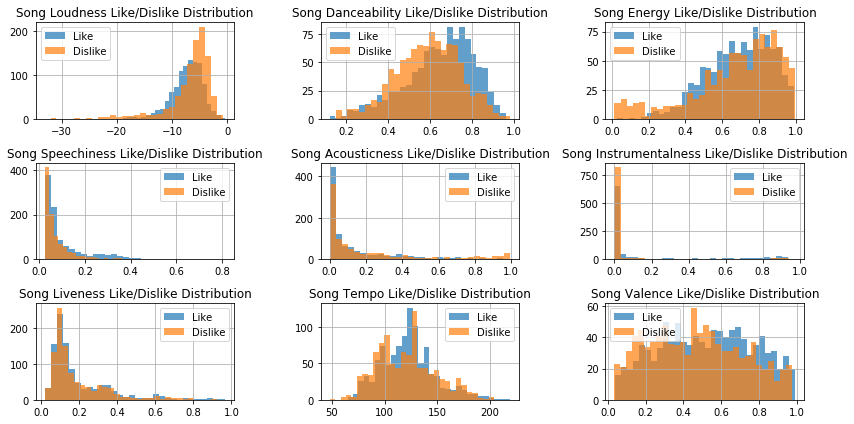

In [118]:
pos_loudness = data[data['target'] == 1]['loudness']
neg_loudness = data[data['target'] == 0]['loudness']

pos_danceability = data[data['target'] == 1]['danceability']
neg_danceability = data[data['target'] == 0]['danceability']

pos_energy = data[data['target'] == 1]['energy']
neg_energy = data[data['target'] == 0]['energy']

pos_speechiness = data[data['target'] == 1]['speechiness']
neg_speechiness = data[data['target'] == 0]['speechiness']

pos_acousticness = data[data['target'] == 1]['acousticness']
neg_acousticness = data[data['target'] == 0]['acousticness']

pos_instrumentalness = data[data['target'] == 1]['instrumentalness']
neg_instrumentalness = data[data['target'] == 0]['instrumentalness']

pos_liveness = data[data['target'] == 1]['liveness']
neg_liveness = data[data['target'] == 0]['liveness']

pos_tempo = data[data['target'] == 1]['tempo']
neg_tempo = data[data['target'] == 0]['tempo']

pos_valence = data[data['target'] == 1]['valence']
neg_valence = data[data['target'] == 0]['valence']

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(331)
ax.set_title("Song Loudness Like/Dislike Distribution")
pos_loudness.hist(alpha=0.7, bins=30, label='Like')
neg_loudness.hist(alpha=0.7, bins=30, label='Dislike')
ax.legend(loc="upper left")

ax2 = fig.add_subplot(332)
ax2.set_title("Song Danceability Like/Dislike Distribution")
pos_danceability.hist(alpha=0.7, bins=30, label='Like')
neg_danceability.hist(alpha=0.7, bins=30, label='Dislike')
ax2.legend(loc="upper left")

ax3 = fig.add_subplot(333)
ax3.set_title("Song Energy Like/Dislike Distribution")
pos_energy.hist(alpha=0.7, bins=30, label='Like')
neg_energy.hist(alpha=0.7, bins=30, label='Dislike')
ax3.legend(loc="upper left")

ax4 = fig.add_subplot(334)
ax4.set_title("Song Speechiness Like/Dislike Distribution")
pos_speechiness.hist(alpha=0.7, bins=30, label='Like')
neg_speechiness.hist(alpha=0.7, bins=30, label='Dislike')
ax4.legend(loc="upper right")

ax5 = fig.add_subplot(335)
ax5.set_title("Song Acousticness Like/Dislike Distribution")
pos_acousticness.hist(alpha=0.7, bins=30, label='Like')
neg_acousticness.hist(alpha=0.7, bins=30, label='Dislike')
ax5.legend(loc="upper right")

ax6 = fig.add_subplot(336)
ax6.set_title("Song Instrumentalness Like/Dislike Distribution")
pos_instrumentalness.hist(alpha=0.7, bins=30, label='Like')
neg_instrumentalness.hist(alpha=0.7, bins=30, label='Dislike')
ax6.legend(loc="upper right")

ax7 = fig.add_subplot(337)
ax7.set_title("Song Liveness Like/Dislike Distribution")
pos_liveness.hist(alpha=0.7, bins=30, label='Like')
neg_liveness.hist(alpha=0.7, bins=30, label='Dislike')
ax7.legend(loc="upper right")

ax8 = fig.add_subplot(338)
ax8.set_title("Song Tempo Like/Dislike Distribution")
pos_tempo.hist(alpha=0.7, bins=30, label='Like')
neg_tempo.hist(alpha=0.7, bins=30, label='Dislike')
ax8.legend(loc="upper right")

ax9 = fig.add_subplot(339)
ax9.set_title("Song Valence Like/Dislike Distribution")
pos_valence.hist(alpha=0.7, bins=30, label='Like')
neg_valence.hist(alpha=0.7, bins=30, label='Dislike')
ax9.legend(loc="upper left")

plt.tight_layout()

Text(0,0.5,'Response')

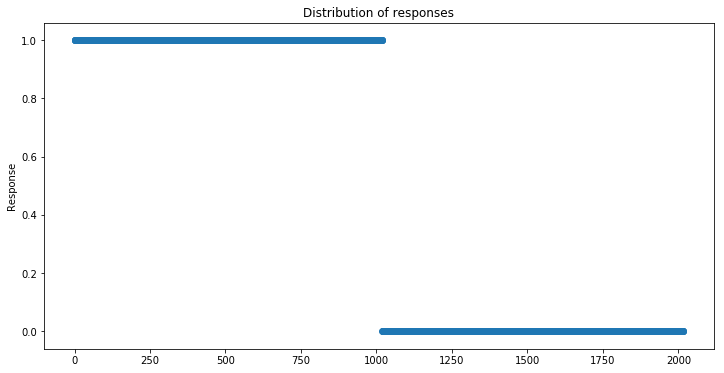

In [120]:
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
x = np.arange(len(data))
y = data['target']
ax.scatter(x,y)
ax.set_title('Distribution of responses')
ax.set_ylabel('Response')

No problem here with the distribution of positive and negative responses

## Model

In [ ]:
# X = data.drop(['song_title','artist','target'], axis = 1).values
# X_const = add_constant(X, prepend=True)
x = data.drop(['song_title','artist','target'], axis = 1).values #returns a numpy array
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
X = pd.DataFrame(x_scaled)
y = data['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Recall of logistic regression classifier on test set: {:.2f}'.format(recall_score(y_test,y_pred)))
print('Precision of logistic regression classifier on test set: {:.2f}'.format(precision_score(y_test,y_pred)))
print('F1 Score of logistic regression classifier on test set: {:.2f}'.format(f1_score(y_test,y_pred)))
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'recall'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation recall accuracy: %.3f" % (results.mean()))
print(classification_report(y_test, y_pred))
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure(figsize = (12,6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [ ]:
type(confusion_matrix)
conf = pd.DataFrame(confusion_matrix)

In [ ]:
import six
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=11.5,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(conf.reset_index(), header_columns=0, col_width=2.0)